# Build and Evaluate a Linear Risk model

Welcome to the first assignment in Course 2!

In this assignment, you'll build a risk score model for retinopathy in diabetes patients using logistic regression.

As we develop the model, we will learn about the following topics:

- Data preprocessing
  - Log transformations
  - Standardization
- Basic Risk Models
  - Logistic Regression
  - C-index
  - Interactions Terms
  
### Diabetic Retinopathy
Retinopathy is an eye condition that causes changes to the blood vessels in the part of the eye called the retina.
This often leads to vision changes or blindness.
Diabetic patients are known to be at high risk for retinopathy. 
    
### Logistic Regression    
Logistic regression is an appropriate analysis to use for predicting the probability of a binary outcome. In our case, this would be the probability of having or not having diabetic retinopathy.
Logistic Regression is one of the most commonly used algorithms for binary classification. It is used to find the best fitting model to describe the relationship between a set of features (also referred to as input, independent, predictor, or explanatory variables) and a binary outcome label (also referred to as an output, dependent, or response variable). Logistic regression has the property that the output prediction is always in the range $[0,1]$. Sometimes this output is used to represent a probability from 0%-100%, but for straight binary classification, the output is converted to either $0$ or $1$ depending on whether it is below or above a certain threshold, usually $0.5$.

It may be  confusing that the term regression appears in the name even though logistic regression is actually a classification algorithm, but that's just a name it was given for historical reasons.

## Table of Contents

- [1. Import Packages](#1)
- [2. Load Data](#2)
- [3. Explore the Dataset](#3)
- [4. Mean-Normalize the Data](#4)
    - [Exercise 1 - make_standard_normal](#ex-1)
- [5. Build the Model](#5)
    - [Exercise 2 - lr_model](#ex-2)
- [6. Evaluate the Model Using the C-Index](#6)
    - [Exercise 3 - cindex](#ex-3)
- [7. Evaluate the Model on the Test Set](#7)
- [8. Improve the Model](#8)
    - [Exercise 4 - add_interactions](#ex-4)
- [9. Evalute the Improved Model](#9)

<a name='1'></a>
## 1.  Import Packages

We'll first import all the packages that we need for this assignment. 

- `numpy` is the fundamental package for scientific computing in python.
- `pandas` is what we'll use to manipulate our data.
- `matplotlib` is a plotting library.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from utils import load_data

from public_tests import *

<a name='2'></a>
## 2. Load Data

First we will load in the dataset that we will use for training and testing our model.

- Run the next cell to load the data that is stored in csv files.
- There is a function `load_data` which randomly generates data, but for consistency, please use the data from the csv files.

In [2]:
# This function creates randomly generated data
# X, y = load_data(6000)

# For stability, load data from files that were generated using the load_data
X = pd.read_csv('data/X_data.csv',index_col=0)
y_df = pd.read_csv('data/y_data.csv',index_col=0)
y = y_df['y']

`X` and `y` are Pandas DataFrames that hold the data for 6,000 diabetic patients. 

<a name='3'></a>
##  3. Explore the Dataset

The features (`X`) include the following fields:
* Age: (years)
* Systolic_BP: Systolic blood pressure (mmHg)
* Diastolic_BP: Diastolic blood pressure (mmHg)
* Cholesterol: (mg/DL)
    
We can use the `head()` method to display the first few records of each.    

In [3]:
X.head()

,Age,Systolic_BP,Diastolic_BP,Cholesterol
0,77.196340,85.288742,80.021878,79.957109
1,63.529850,99.379736,84.852361,110.382411
2,69.003986,111.349455,109.850616,100.828246
3,82.638210,95.056128,79.666851,87.066303
4,78.346286,109.154591,90.713220,92.511770


The target (`y`) is an indicator of whether or not the patient developed retinopathy.

* y = 1 : patient has retinopathy.
* y = 0 : patient does not have retinopathy.

In [4]:
y.head()

0    1.0
1    1.0
2    1.0
3    1.0
4    1.0
Name: y, dtype: float64

Before we build a model, let's take a closer look at the distribution of our training data. To do this, we will split the data into train and test sets using a 75/25 split.

For this, we can use the built in function provided by sklearn library.  See the documentation for [sklearn.model_selection.train_test_split](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html). 

In [5]:
from sklearn.model_selection import train_test_split

In [6]:
X_train_raw, X_test_raw, y_train, y_test = train_test_split(X, y, train_size=0.75, random_state=0)

Plot the histograms of each column of `X_train` below: 

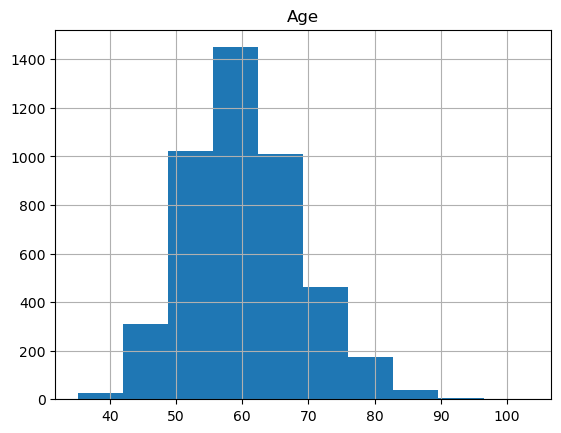

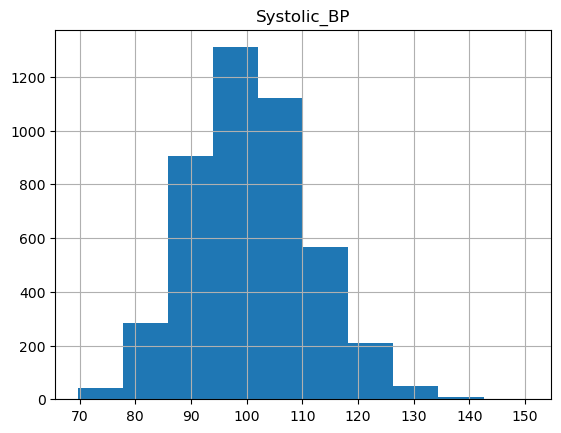

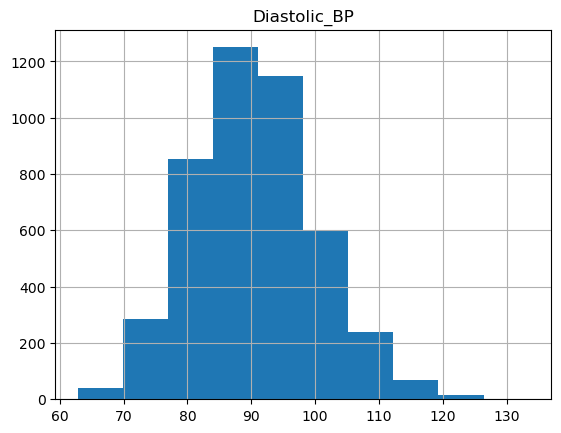

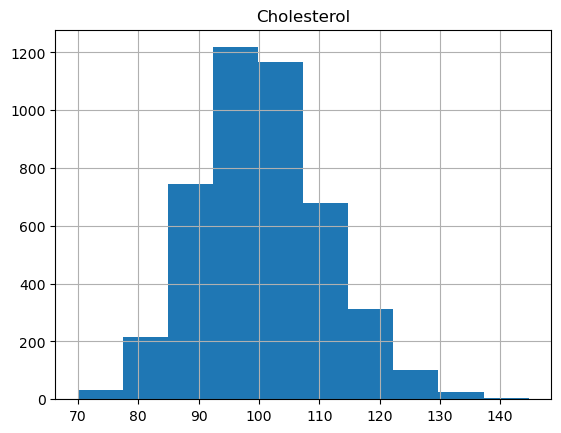

In [7]:
for col in X.columns:
    X_train_raw.loc[:, col].hist()
    plt.title(col)
    plt.show()

As we can see, the distributions have a generally bell shaped distribution, but with slight rightward skew.

Many statistical models assume that the data is normally distributed, forming a symmetric Gaussian bell shape (with no skew) more like the example below.

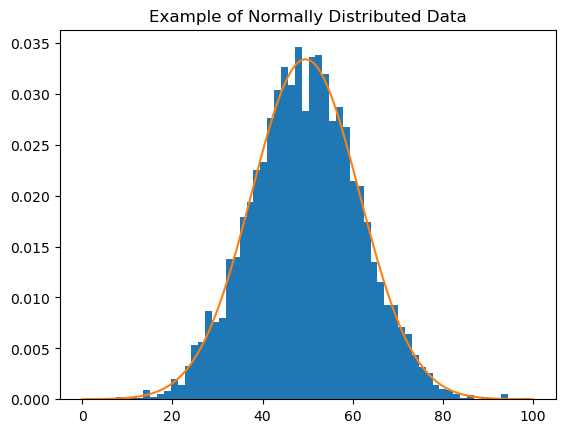

In [8]:
from scipy.stats import norm
data = np.random.normal(50,12, 5000)
fitting_params = norm.fit(data)
norm_dist_fitted = norm(*fitting_params)
t = np.linspace(0,100, 100)
plt.hist(data, bins=60, density=True)
plt.plot(t, norm_dist_fitted.pdf(t))
plt.title('Example of Normally Distributed Data')
plt.show()

We can transform our data to be closer to a normal distribution by removing the skew. One way to remove the skew is by applying the log function to the data.

Let's plot the log of the feature variables to see that it produces the desired effect.

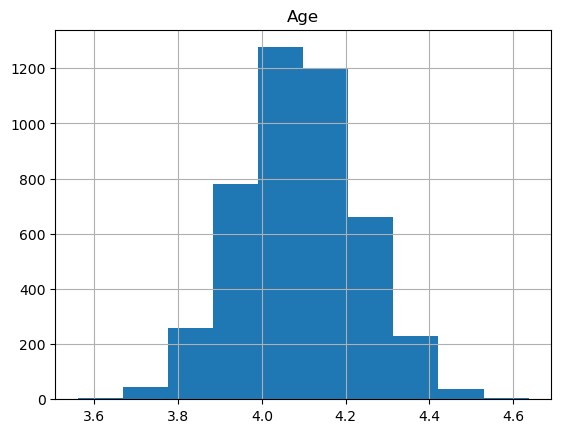

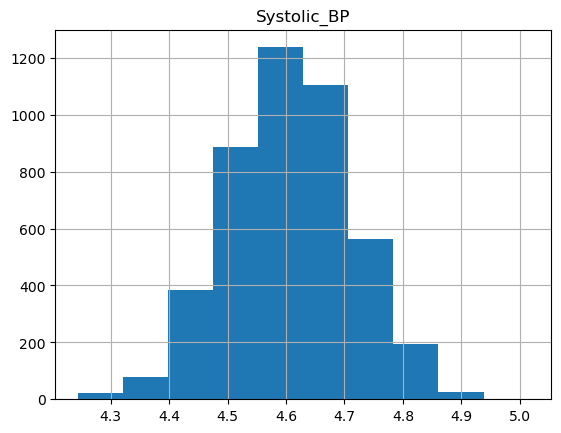

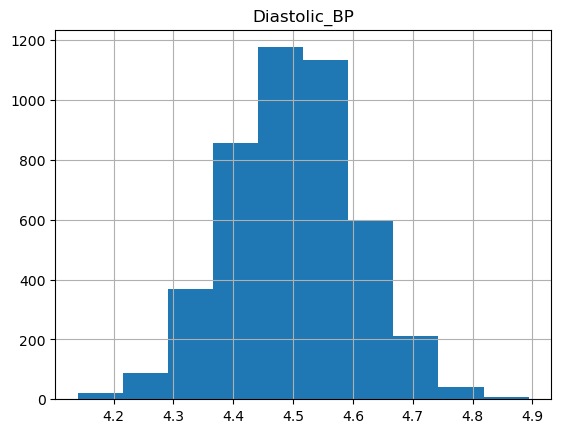

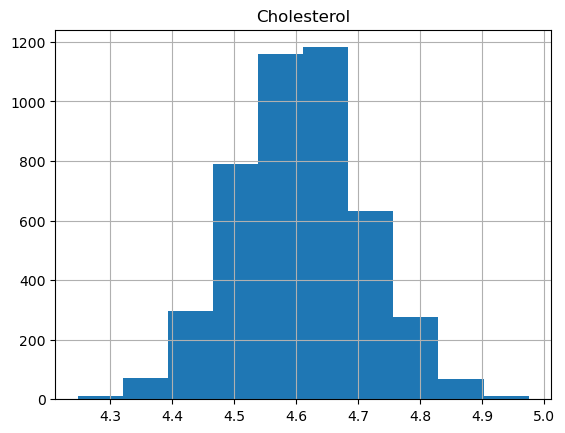

In [9]:
for col in X_train_raw.columns:
    np.log(X_train_raw.loc[:, col]).hist()
    plt.title(col)
    plt.show()

We can see that the data is more symmetric after taking the log.

<a name='4'></a>
## 4. Mean-Normalize the Data

Let's now transform our data so that the distributions are closer to standard normal distributions.

First we will remove some of the skew from the distribution by using the log transformation.
Then we will "standardize" the distribution so that it has a mean of zero and standard deviation of 1. Recall that a standard normal distribution has mean of zero and standard deviation of 1. 

<a name='ex-1'></a>
### Exercise 1 - make_standard_normal
* Write a function that first removes some of the skew in the data, and then standardizes the distribution so that for each data point $x$,
$$\overline{x} = \frac{x - mean(x)}{std(x)}$$
* Keep in mind that we want to pretend that the test data is "unseen" data. 
    * This implies that it is unavailable to us for the purpose of preparing our data, and so we do not want to consider it when evaluating the mean and standard deviation that we use in the above equation. Instead we want to calculate these values using the training data alone, but then use them for standardizing both the training and the test data.
    * For a further discussion on the topic, see this article ["Why do we need to re-use training parameters to transform test data"](https://sebastianraschka.com/faq/docs/scale-training-test.html). 

#### Note
- For the sample standard deviation, please calculate the unbiased estimator:
$$s = \sqrt{\frac{\sum_{i=1}^n(x_{i} - \bar{x})^2}{n-1}}$$
- In other words, if you numpy, set the degrees of freedom `ddof` to 1.
- For pandas, the default `ddof` is already set to 1.

<details>    
<summary>
    <font size="3" color="darkgreen"><b>Hints</b></font>
</summary>
<p>
    <ul>
        <li> When working with Pandas DataFrames, you can use the aggregation functions <code>mean</code> and <code>std</code> functions. Note that in order to apply an aggregation function separately for each row or each column, you'll set the axis parameter to either 0 or 1. One produces the aggregation along columns and the other along rows, but it is easy to get them confused. So experiment with each option below to see which one you should use to get an average for each column in the dataframe.
<code>
avg = df.mean(axis=0)
avg = df.mean(axis=1) 
</code>
        </li>
        <li>Remember to use **training** data statistics when standardizing both the training and the test data.</li>
    </ul>
</p>
</details> 

In [30]:
# UNQ_C1 (UNIQUE CELL IDENTIFIER, DO NOT EDIT)
def make_standard_normal(df_train, df_test):
    """
    In order to make the data closer to a normal distribution, take log
    transforms to reduce the skew.
    Then standardize the distribution with a mean of zero and standard deviation of 1. 
  
    Args:
      df_train (dataframe): unnormalized training data.
      df_test (dataframe): unnormalized test data.
  
    Returns:
      df_train_normalized (dateframe): normalized training data.
      df_test_normalized (dataframe): normalized test data.
    """
    
    ### START CODE HERE (REPLACE INSTANCES OF 'None' with your code) ###  
    # Remove skew by applying the log function to the train set, and to the test set
    df_train_unskewed = df_train.apply(np.log)
    df_test_unskewed = df_test.apply(np.log)
    
    #calculate the mean and standard deviation of the training set
    mean = df_train_unskewed.mean(axis = 0)
    stdev = df_train_unskewed.std(axis = 0)
    
    # standardize the training set
    df_train_standardized = (df_train_unskewed - mean)/stdev
    
    # standardize the test set (see instructions and hints above)
    df_test_standardized = (df_test_unskewed - mean)/stdev
    
    ### END CODE HERE ###
    return df_train_standardized, df_test_standardized

In [31]:
### test cell ex1: do not edit this cell
make_standard_normal_test(make_standard_normal)    

Tmp Train:

    field1  field2
0       1       4
1       2       5
2      10      11 

Tmp Test:

    field1  field2
0       1       4
1       3       6
2      10      11 

Tmp Train After Standard Normal:

      field1    field2
0 -0.845330 -0.774414
1 -0.258557 -0.354556
2  1.103887  1.128970 

Tmp Test After Standard Normal:

      field1    field2
0 -0.845330 -0.774414
1  0.084683 -0.011508
2  1.103887  1.128970 

Training set transformed field1 has mean -7.401486830834377e-17 and standard deviation 1.0000 
Test set transformed, field1 has mean 0.11441332564321975 and standard deviation 0.9749
Skew of training set field1 before transformation: 1.6523167403329906
Skew of training set field1 after transformation: 1.0857243344604632
Skew of test set field1 before transformation: 1.3896361387064917
Skew of test set field1 after transformation: 0.13709698849045696

 All tests passed.


#### Expected Output
```
Training set transformed field1 has mean -7.401486830834377e-17 and standard deviation 1.0000 
Test set transformed, field1 has mean 0.11441332564321975 and standard deviation 0.9749
Skew of training set field1 before transformation: 1.6523167403329906
Skew of training set field1 after transformation: 1.0857243344604632
Skew of test set field1 before transformation: 1.3896361387064917
Skew of test set field1 after transformation: 0.13709698849045696

 All tests passed.
```

#### Transform training and test data 
Use the function that you just implemented to make the data distribution closer to a standard normal distribution.

In [32]:
X_train, X_test = make_standard_normal(X_train_raw, X_test_raw)

After transforming the training and test sets, we'll expect the training set to be centered at zero with a standard deviation of $1$.

We will avoid observing the test set during model training in order to avoid biasing the model training process, but let's have a look at the distributions of the transformed training data.

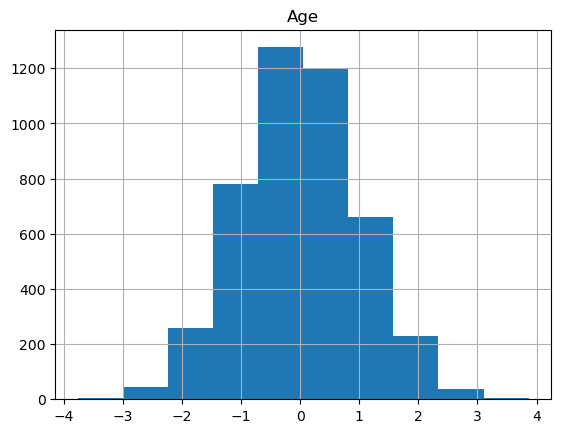

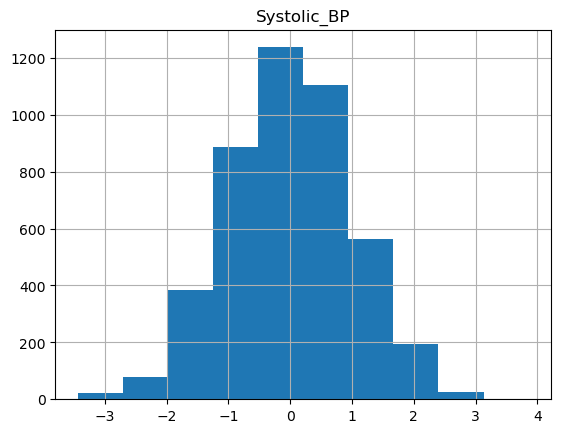

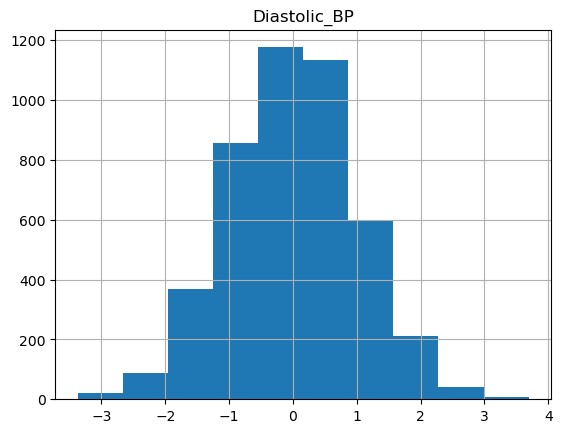

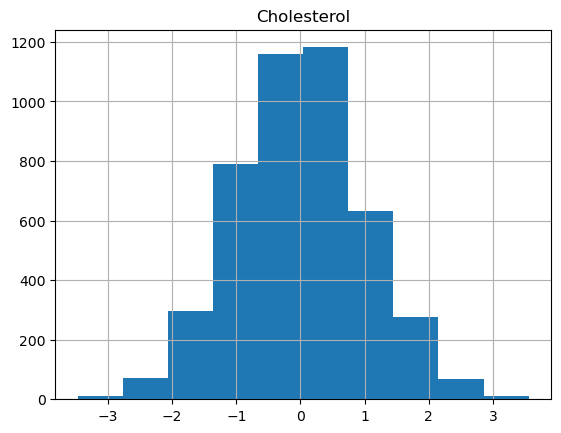

In [33]:
for col in X_train.columns:
    X_train[col].hist()
    plt.title(col)
    plt.show()

<a name='5'></a>
## 5. Build the Model

Now we are ready to build the risk model by training logistic regression with our data.



<a name='ex-2'></a>
### Exercise 2 - lr_model

* Implement the `lr_model` function to build a model using logistic regression with the `LogisticRegression` class from `sklearn`. 
* See the documentation for [sklearn.linear_model.LogisticRegression](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html#sklearn.linear_model.LogisticRegression.fit).

<details>    
<summary>
    <font size="3" color="darkgreen"><b>Hints</b></font>
</summary>
<p>
    <ul>
        <li>You can leave all the parameters to their default values when constructing an instance of the <code>sklearn.linear_model.LogisticRegression</code> class. If you get a warning message regarding the <code>solver</code> parameter, however, you may want to specify that particular one explicitly with <code>solver='lbfgs'</code>. 
        </li>
        <br></br>
    </ul>
</p>
</details> 

In [36]:
# UNQ_C2 (UNIQUE CELL IDENTIFIER, DO NOT EDIT)
def lr_model(X_train, y_train):
    
    ### START CODE HERE (REPLACE INSTANCES OF 'None' with your code) ###
    # import the LogisticRegression class
    from sklearn.linear_model import LogisticRegression
    
    # create the model object
    model = LogisticRegression()
    
    # fit the model to the training data
    model.fit(X_train, y_train)
    
    ### END CODE HERE ###
    #return the fitted model
    return model

#### Test Your Work

Note: the `predict` method returns the model prediction *after* converting it from a value in the $[0,1]$ range to a $0$ or $1$ depending on whether it is below or above $0.5$.

In [37]:
### test cell ex2: do not edit this cell
lr_model_test(lr_model, X_train, y_train)    

X_train[4:5] value: [1.] 
X_train[5:6] value: [1.] 

 All tests passed.


#### Expected Output
```
X_train[4:5] value: [1.] 
X_train[5:6] value: [1.] 

 All tests passed.
```

Now that we've tested our model, we can go ahead and build it. Note that the `lr_model` function also fits  the model to the training data.

In [38]:
model_X = lr_model(X_train, y_train)

<a name='6'></a>
## 6. Evaluate the Model Using the C-index

Now that we have a model, we need to evaluate it. We'll do this using the c-index. 
* The c-index measures the discriminatory power of a risk score. 
* Intuitively, a higher c-index indicates that the model's prediction is in agreement with the actual outcomes of a pair of patients.
* The formula for the c-index is

$$ \mbox{cindex} = \frac{\mbox{concordant} + 0.5 \times \mbox{ties}}{\mbox{permissible}} $$

* A permissible pair is a pair of patients who have different outcomes.
* A concordant pair is a permissible pair in which the patient with the higher risk score also has the worse outcome.
* A tie is a permissible pair where the patients have the same risk score.



<a name='ex-3'></a>
### Exercise 3 - cindex

* Implement the `cindex` function to compute c-index.
* `y_true` is the array of actual patient outcomes, 0 if the patient does not eventually get the disease, and 1 if the patient eventually gets the disease.
* `scores` is the risk score of each patient.  These provide relative measures of risk, so they can be any real numbers. By convention, they are always non-negative.
* Here is an example of input data and how to interpret it:
```Python
y_true = [0,1]
scores = [0.45, 1.25]
```
    * There are two patients. Index 0 of each array is associated with patient 0.  Index 1 is associated with patient 1.
    * Patient 0 does not have the disease in the future (`y_true` is 0), and based on past information, has a risk score of 0.45.
    * Patient 1 has the disease at some point in the future (`y_true` is 1), and based on past information, has a risk score of 1.25.

In [39]:
# UNQ_C3 (UNIQUE CELL IDENTIFIER, DO NOT EDIT)
def cindex(y_true, scores):
    '''

    Input:
    y_true (np.array): a 1-D array of true binary outcomes (values of zero or one)
        0: patient does not get the disease
        1: patient does get the disease
    scores (np.array): a 1-D array of corresponding risk scores output by the model

    Output:
    c_index (float): (concordant pairs + 0.5*ties) / number of permissible pairs
    '''
    n = len(y_true)
    assert len(scores) == n

    concordant = 0
    permissible = 0
    ties = 0
    
    ### START CODE HERE (REPLACE INSTANCES OF 'None' with your code) ###
    # use two nested for loops to go through all unique pairs of patients
    for i in range(n):
        for j in range(i+1, n): #choose the range of j so that j>i
            
            # Check if the pair is permissible (the patient outcomes are different)
            if y_true[i] != y_true[j]:
                # Count the pair if it's permissible
                permissible += 1

                # For permissible pairs, check if they are concordant or are ties

                # check for ties in the score
                if scores[i] == scores[j]:
                    # count the tie
                    ties += 1
                    # if it's a tie, we don't need to check patient outcomes, continue to the top of the for loop.
                    continue

                # case 1: patient i doesn't get the disease, patient j does
                if y_true[i] == 0 and y_true[j] == 1:
                    # Check if patient i has a lower risk score than patient j
                    if scores[i] < scores[j]:
                        # count the concordant pair
                        concordant += 1
                    # Otherwise if patient i has a higher risk score, it's not a concordant pair.
                    # Already checked for ties earlier

                # case 2: patient i gets the disease, patient j does not
                if y_true[i] == 1 and y_true[j] == 0:
                    # Check if patient i has a higher risk score than patient j
                    if scores[i] > scores[j]:
                        #count the concordant pair
                        concordant += 1
                    # Otherwise if patient i has a lower risk score, it's not a concordant pair.
                    # We already checked for ties earlier

    # calculate the c-index using the count of permissible pairs, concordant pairs, and tied pairs.
    c_index = (concordant + 0.5 * ties) / permissible
    ### END CODE HERE ###
    
    return c_index

In [40]:
### test cell ex3: do not edit this cell
cindex_test(cindex)    

Test Case 1:

Y_true:  [1. 0. 0. 1.]
Scores:  [0 1 1 0]
cindex for test case 1:  0.0

Test Case 2:

Y_true:  [1. 0. 0. 1.]
Scores:  [1 0 0 1]
cindex for test case 2:  1.0

Test Case 3:

Y_true:  [1. 0. 0. 1.]
Scores:  [0.5 0.5 0.  1. ]
cindex for test case 3:  0.875 

 All tests passed.


#### Expected Output

```
Test Case 1:

cindex for test case 1:  0.0

Test Case 2:

cindex for test case 2:  1.0

Test Case 3:

cindex for test case 3:  0.875 

 All tests passed.
```

<a name='7'></a>
## 7. Evaluate the Model on the Test Set

Now, you can evaluate your trained model on the test set.  

To get the predicted probabilities, we use the `predict_proba` method. This method will return the result from the model *before* it is converted to a binary 0 or 1. For each input case, it returns an array of two values which represent the probabilities for both the negative case (patient does not get the disease) and positive case (patient the gets the disease). 

In [41]:
scores = model_X.predict_proba(X_test)[:, 1]
c_index_X_test = cindex(y_test.values, scores)
print(f"c-index on test set is {c_index_X_test:.4f}")

c-index on test set is 0.8182


#### Expected output
```CPP
c-index on test set is 0.8182
```

Let's plot the coefficients to see which variables (patient features) are having the most effect. You can access the model coefficients by using `model.coef_`

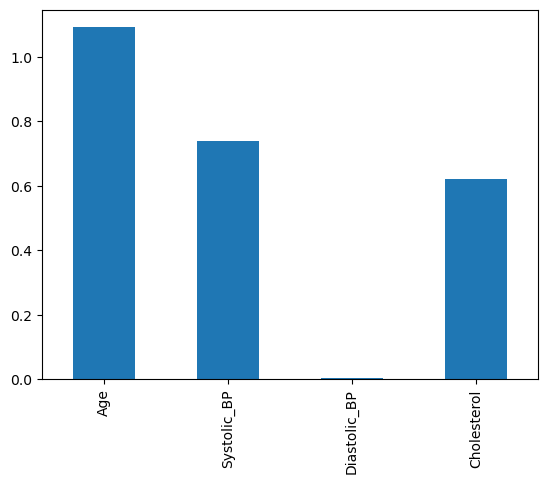

In [42]:
coeffs = pd.DataFrame(data = model_X.coef_, columns = X_train.columns)
coeffs.T.plot.bar(legend=None);

### Question: 
> __Which three variables have the largest impact on the model's predictions?__

<a name='8'></a>
## 8. Improve the Model

You can try to improve your model by including interaction terms. 
* An interaction term is the product of two variables. 
    * For example, if we have data 
    $$ x = [x_1, x_2]$$
    * We could add the product so that:
    $$ \hat{x} = [x_1, x_2, x_1*x_2]$$
    


<a name='ex-4'></a>
### Exercise 4 - add_interactions

Write code below to add all interactions between every pair of variables to the training and test datasets. 

In [62]:
# UNQ_C4 (UNIQUE CELL IDENTIFIER, DO NOT EDIT)
def add_interactions(X):
    """
    Add interaction terms between columns to dataframe.

    Args:
    X (dataframe): Original data

    Returns:
    X_int (dataframe): Original data with interaction terms appended. 
    """
    features = X.columns
    m = len(features)
    X_int = X.copy(deep=True)

    ### START CODE HERE (REPLACE INSTANCES OF 'None' with your code) ###
    # 'i' loops through all features in the original dataframe X
    for i in range(len(features)):
        
        # get the name of feature 'i'
        feature_i_name = features[i]
        
        # get the data for feature 'i'
        feature_i_data = X[feature_i_name]
        
        # choose the index of column 'j' to be greater than column i
        for j in range(i+1, m):
            
            # get the name of feature 'j'
            feature_j_name = features[j]
            
            # get the data for feature j'
            feature_j_data = X[feature_j_name]
            
            # create the name of the interaction feature by combining both names
            # example: "apple" and "orange" are combined to be "apple_x_orange"
            feature_i_j_name = f"{feature_i_name}_x_{feature_j_name}"
            
            # Multiply the data for feature 'i' and feature 'j'
            # store the result as a column in dataframe X_int
            X_int[feature_i_j_name] = feature_i_data * feature_j_data
        
    ### END CODE HERE ###

    return X_int

In [63]:
### test cell ex4: do not edit this cell
add_interactions_test(add_interactions, X_train)

Original Data

           Age  Systolic_BP
1824 -0.912451    -0.068019
253  -0.302039     1.719538
1114  2.576274     0.155962
3220  1.163621    -2.033931
2108 -0.446238    -0.054554

Data with Interactions

           Age  Systolic_BP  Age_x_Systolic_BP
1824 -0.912451    -0.068019           0.062064
253  -0.302039     1.719538          -0.519367
1114  2.576274     0.155962           0.401800
3220  1.163621    -2.033931          -2.366725
2108 -0.446238    -0.054554           0.024344 

Error: Wrong output. for variable in position 0.
Error: Wrong output. for variable in position 1.
Error: Wrong output. for variable in position 2.
Error: Wrong output. for variable in position 3.
Error: Wrong output. for variable in position 4.
 2  Tests passed
 1  Tests failed


AssertionError: Not all tests were passed for test_target. Check your equations and avoid using global variables inside the function.

#### Expected Output
```
Original Data

           Age  Systolic_BP
1824 -0.912451    -0.068019
253  -0.302039     1.719538
1114  2.576274     0.155962
3220  1.163621    -2.033931
2108 -0.446238    -0.054554

Data with Interactions

           Age  Systolic_BP  Age_x_Systolic_BP
1824 -0.912451    -0.068019           0.062064
253  -0.302039     1.719538          -0.519367
1114  2.576274     0.155962           0.401800
3220  1.163621    -2.033931          -2.366725
2108 -0.446238    -0.054554           0.024344
 
 All tests passed.
```

Once you have correctly implemented `add_interactions`, use it to make transformed version of `X_train` and `X_test`.

In [64]:
X_train_int = add_interactions(X_train)
X_test_int = add_interactions(X_test)

<a name='9'></a>
## 9. Evaluate the Improved Model

Now we can train the new and improved version of the model.

In [65]:
model_X_int = lr_model(X_train_int, y_train)

Let's evaluate our new model on the test set.

In [66]:
scores_X = model_X.predict_proba(X_test)[:, 1]
c_index_X_int_test = cindex(y_test.values, scores_X)

scores_X_int = model_X_int.predict_proba(X_test_int)[:, 1]
c_index_X_int_test = cindex(y_test.values, scores_X_int)

print(f"c-index on test set without interactions is {c_index_X_test:.4f}")
print(f"c-index on test set with interactions is {c_index_X_int_test:.4f}")

c-index on test set without interactions is 0.8182
c-index on test set with interactions is 0.8281


You should see that the model with interaction terms performs a bit better than the model without interactions.

Now let's take another look at the model coefficients to try and see which variables made a difference. Plot the coefficients and report which features seem to be the most important.

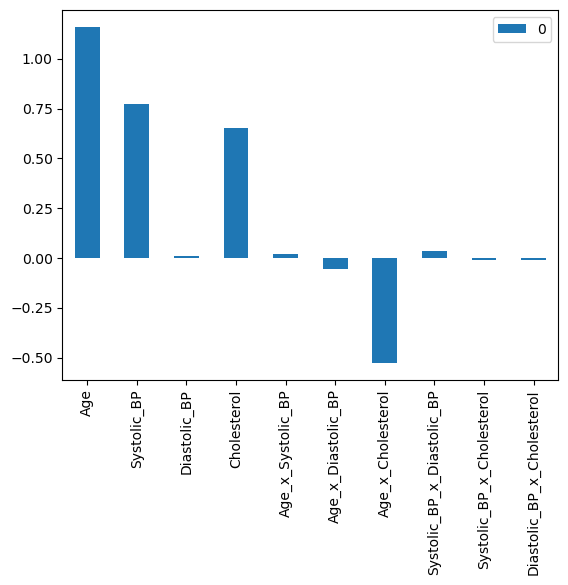

In [67]:
int_coeffs = pd.DataFrame(data = model_X_int.coef_, columns = X_train_int.columns)
int_coeffs.T.plot.bar();

### Questions:
> __Which variables are most important to the model?__<br>
> __Have the relevant variables changed?__<br>
> __What does it mean when the coefficients are positive or negative?__<br>

You may notice that Age, Systolic_BP, and Cholesterol have a positive coefficient. This means that a higher value in these three features leads to a higher prediction probability for the disease. You also may notice that the interaction of Age x Cholesterol has a negative coefficient. This means that a higher value for the Age x Cholesterol product reduces the prediction probability for the disease.

To understand the effect of interaction terms, let's compare the output of the model we've trained on sample cases with and without the interaction. Run the cell below to choose an index and look at the features corresponding to that case in the training set. 

In [68]:
index = index = 3432
case = X_train_int.iloc[index, :]
print(case)

Age                           2.502061
Systolic_BP                   1.713547
Diastolic_BP                  0.268265
Cholesterol                   2.146349
Age_x_Systolic_BP             4.287400
Age_x_Diastolic_BP            0.671216
Age_x_Cholesterol             5.370296
Systolic_BP_x_Diastolic_BP    0.459685
Systolic_BP_x_Cholesterol     3.677871
Diastolic_BP_x_Cholesterol    0.575791
Name: 5970, dtype: float64


We can see that they have above average Age and Cholesterol. We can now see what our original model would have output by zero-ing out the value for Cholesterol and Age.

In [69]:
new_case = case.copy(deep=True)
new_case.loc["Age_x_Cholesterol"] = 0
new_case

Age                           2.502061
Systolic_BP                   1.713547
Diastolic_BP                  0.268265
Cholesterol                   2.146349
Age_x_Systolic_BP             4.287400
Age_x_Diastolic_BP            0.671216
Age_x_Cholesterol             0.000000
Systolic_BP_x_Diastolic_BP    0.459685
Systolic_BP_x_Cholesterol     3.677871
Diastolic_BP_x_Cholesterol    0.575791
Name: 5970, dtype: float64

In [70]:
print(f"Output with interaction: \t{model_X_int.predict_proba([case.values])[:, 1][0]:.4f}")
print(f"Output without interaction: \t{model_X_int.predict_proba([new_case.values])[:, 1][0]:.4f}")

Output with interaction: 	0.9448
Output without interaction: 	0.9965


C:\Users\Staff Asia\anaconda3\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
C:\Users\Staff Asia\anaconda3\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(


#### Expected output
```CPP
Output with interaction: [0.94482095]
Output without interaction: [0.99653789]
```

We see that the model is less confident in its prediction with the interaction term than without (the prediction value is lower when including the interaction term). With the interaction term, the model has adjusted for the fact that the effect of high cholesterol becomes less important for older patients compared to younger patients.

# Congratulations! 

You have finished the first assignment of Course 2. 